In [44]:
using LimberJack
using LinearAlgebra
using CSV
using NPZ
using Plots
using FITSIO
using Random
using GaussianProcess
using PyPlot
using Turing

In [45]:
path = "../chains/"
fol = "DES_cosmo_emul_ϵ0.01/"
run = string(path, fol)
if isdir(run)
    files = readdir(run)
    last_chain = last([file for file in files if occursin("chain", file)])
    last_n = parse(Int, last_chain[7])
end

6

In [46]:
files = npzread("../data/DESY1_cls/Cls_meta.npz")
cov_tot = files["cov"]
data_vector = files["cls"]

fid_cosmo = Cosmology()
N = 100
latent_x = Vector(0:0.3:3)
x = Vector(range(0., stop=3., length=N));
latent_N = length(latent_x)
mu = fid_cosmo.Dz(vec(latent_x));

In [47]:
carlos_params1 = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
                 1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
                -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
                 2.389208e-01,   -6.435288e-01, 
                 1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
                -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
                 8.536883e-01,    2.535825e-01];

In [48]:
pars = carlos_params1
nuisances = Dict("b0" => pars[5],
                 "b1" => pars[6],
                 "b2" => pars[7],
                 "b3" => pars[8],
                 "b4" => pars[9],
                 "dz_g0" => pars[10],
                 "dz_g1" => pars[11],
                 "dz_g2" => pars[12],
                 "dz_g3" => pars[13],
                 "dz_g4" => pars[14],
                 "dz_k0" => pars[21],
                 "dz_k1" => pars[22],
                 "dz_k2" => pars[23],
                 "dz_k3" => pars[24],
                 "mb0" => pars[17],
                 "mb1" => pars[18],
                 "mb2" => pars[19],
                 "mb3" => pars[20],
                 "A_IA" => pars[15],
                 "alpha_IA" => pars[16]);

In [49]:
function model(;kwargs...)
    mu = fid_cosmo.Dz(vec(latent_x))
    K = sqexp_cov_fn(latent_x; eta=kwargs[:eta], l=kwargs[:l])
    latent_gp = latent_GP(mu, kwargs[:v], K)
    gp = conditional(latent_x, x, latent_gp, sqexp_cov_fn;
                      eta=kwargs[:eta], l=kwargs[:l])
    
    cosmology = LimberJack.Cosmology(kwargs[:Ωm], kwargs[:Ωb], kwargs[:h],
                                     kwargs[:ns], kwargs[:s8],
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit", 
                                     custom_Dz=gp)
    
    return latent_gp, gp, Theory(cosmology, files;
                  Nuisances=nuisances)
end;

In [59]:
N_samples = 100
cls_preds = zeros(N_samples, 475)
gps = zeros(N_samples, 100)
latent_gps = zeros(N_samples, 11)
for i in 1:N_samples
    eta = rand(Uniform(0.01, 0.1))
    l = rand(Uniform(0.1, 4))
    v = rand(filldist(truncated(Normal(0, 1), -3, 3), latent_N)) #MvNormal(zeros(latent_N), ones(latent_N)))
    Ωm = rand(Normal(0.3, 0.1))
    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]
    s8 = pars[25]
    latent_gps[i, :], gps[i, :], cls_preds[i,:] = model(eta=eta, l=l, v=v,
                                                        Ωm=Ωm, Ωb=Ωb, h=h, 
                                                        ns=ns, s8=s8)
end

In [60]:
cls_preds_m, cls_preds_s = mean(cls_preds, dims=1), std(cls_preds, dims=1);

In [61]:
gp_m, gp_s = vec(mean(gps, dims=1)), vec(std(gps, dims=1));

In [62]:
latent_gp_m, latent_gp_s = vec(mean(latent_gps, dims=1)), vec(std(latent_gps, dims=1));

# Plots

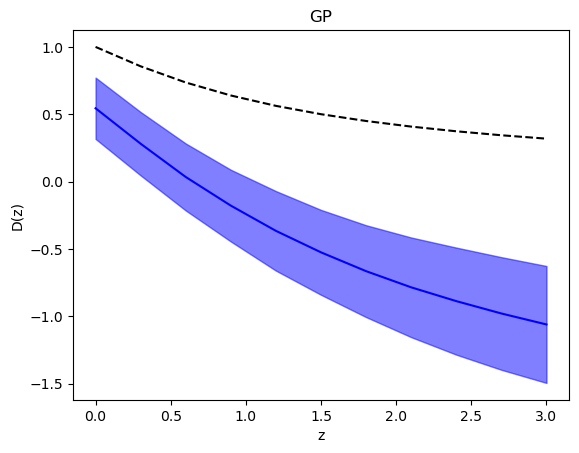

In [63]:
plt.plot(latent_x, mu, "k--")
plt.plot(latent_x, latent_gp_m, "b-", label="GP")
plt.fill_between(latent_x, latent_gp_m.+latent_gp_s,
                 latent_gp_m.-latent_gp_s, color="b", alpha=.5);
plt.xlabel("z")
plt.ylabel("D(z)")
plt.title("GP");

In [18]:
lengths_gcgc = [length(files[string("ls_1", i, "1", i)]) for i in 0:4];

In [19]:
lengths_gcwl = []
for i in 0:4
    for j in 0:3
        append!(lengths_gcwl, length(files[string("ls_1", i, "2", j)]))
    end
end

In [20]:
lengths_wlwl = []
for i in 0:3
    for j in 0:3
        if j >= i 
            append!(lengths_wlwl, length(files[string("ls_2", i,"2", j)]))
        end
    end
end

In [21]:
lengths = vcat([[1], lengths_gcgc, lengths_gcwl, lengths_wlwl]...)
idx = cumsum(lengths);

In [22]:
data = files["cls"]
err = sqrt.(diag(files["cov"]));

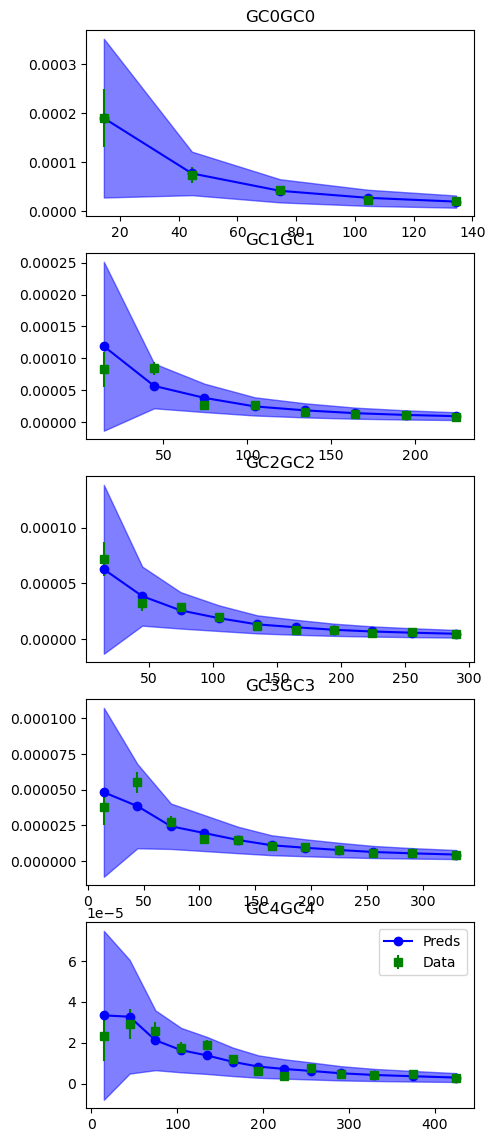

6

In [22]:
figure, axis = plt.subplots(5, figsize=(5,14))
l = 1
for i in 0:4
    axis[i+1].errorbar(files[string("ls_1", i, "1", i)], 
                     data[idx[l]:idx[l+1]-1], 
                     yerr=err[idx[l]:idx[l+1]-1], fmt="gs", label="Data")
    axis[i+1].plot(files[string("ls_1", i, "1", i)],
                   cls_preds_m[idx[l]:idx[l+1]-1],
                   "bo-", label="Preds")
    axis[i+1].fill_between(files[string("ls_1", i, "1", i)],
                   cls_preds_m[idx[l]:idx[l+1]-1].+cls_preds_s[idx[l]:idx[l+1]-1],
                   cls_preds_m[idx[l]:idx[l+1]-1].-cls_preds_s[idx[l]:idx[l+1]-1],
                   color="b", alpha=.5)
    axis[i+1].set_title(string("GC", i, "GC", i))
    l += 1
end
plt.legend()
plt.show()
print(l)

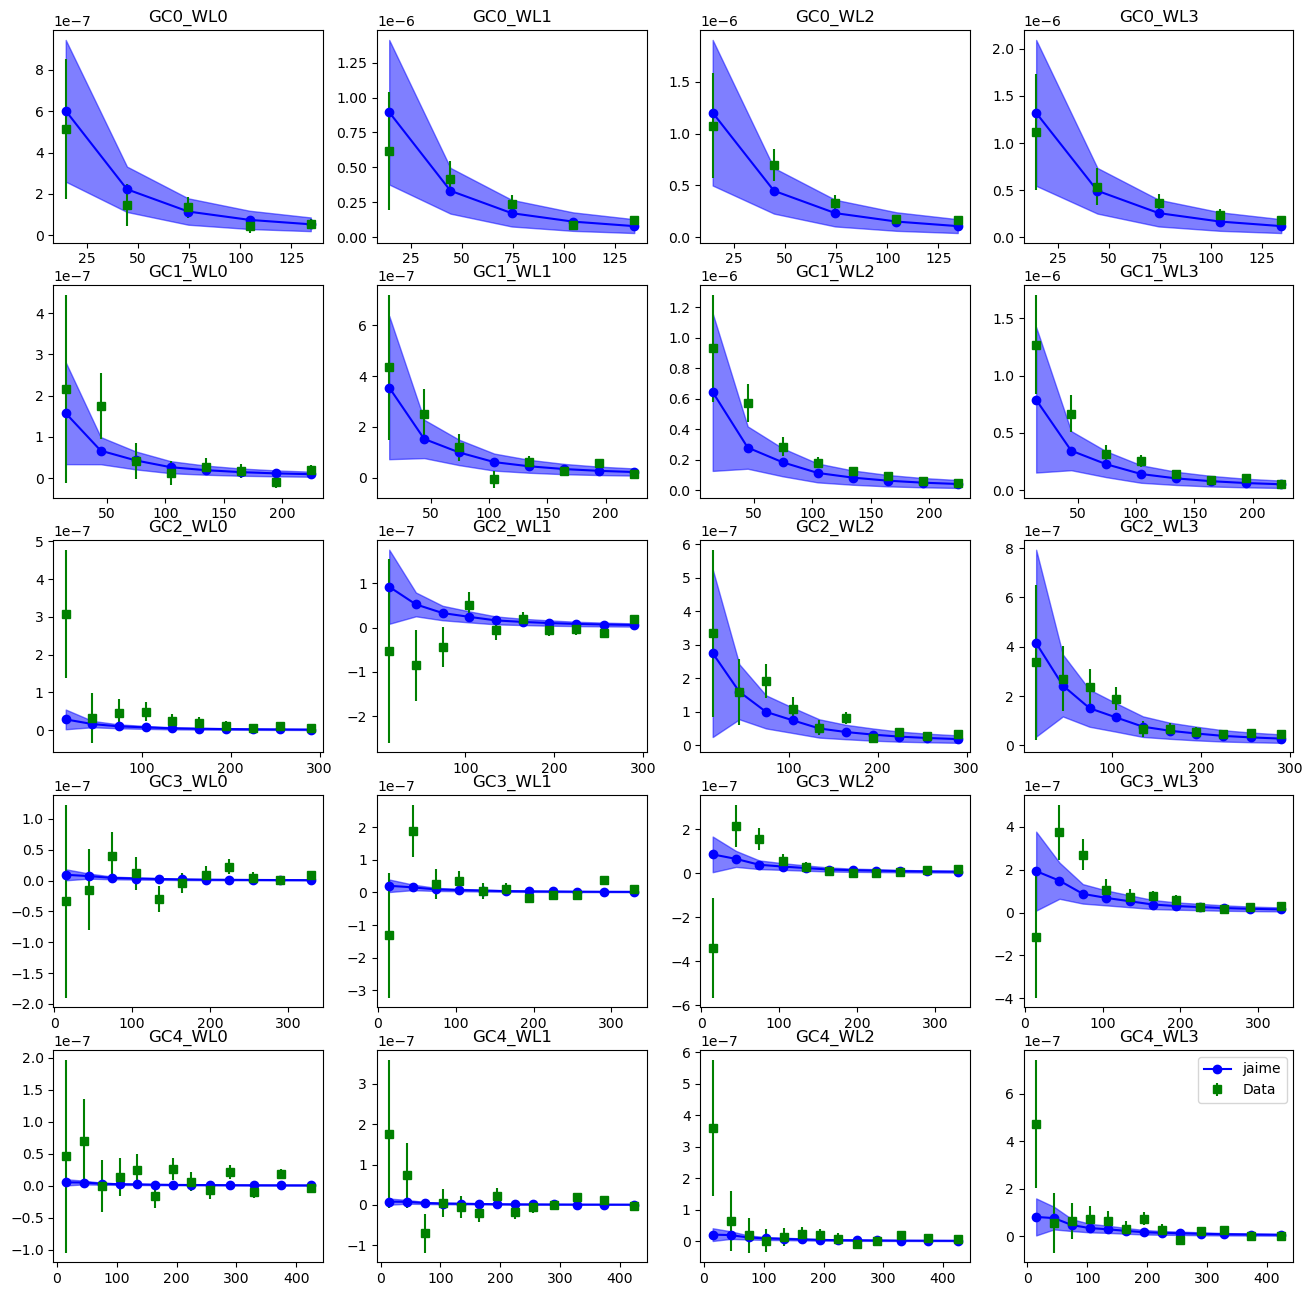

26


In [48]:
figure, axis = plt.subplots(5, 4, figsize=(16,16))
l = 6
for i in 0:4
    for j in 0:3
        axis[i+1, j+1].errorbar(files[string("ls_1", i, "2", j)], 
                       data[idx[l]:idx[l+1]-1], 
                       yerr=err[idx[l]:idx[l+1]-1], fmt="gs", label="Data")
        axis[i+1, j+1].plot(files[string("ls_1", i, "2", j)],
                            cls_preds_m[idx[l]:idx[l+1]-1],
                            "bo-", label="jaime")
        axis[i+1, j+1].fill_between(files[string("ls_1", i, "2", j)],
                            cls_preds_m[idx[l]:idx[l+1]-1].+cls_preds_s[idx[l]:idx[l+1]-1],
                            cls_preds_m[idx[l]:idx[l+1]-1].-cls_preds_s[idx[l]:idx[l+1]-1],
                            color="b", alpha=.5)
        axis[i+1, j+1].set_title(string("GC", i, "_WL", j))
        l += 1
    end
end
plt.legend()
plt.show()
println(l)

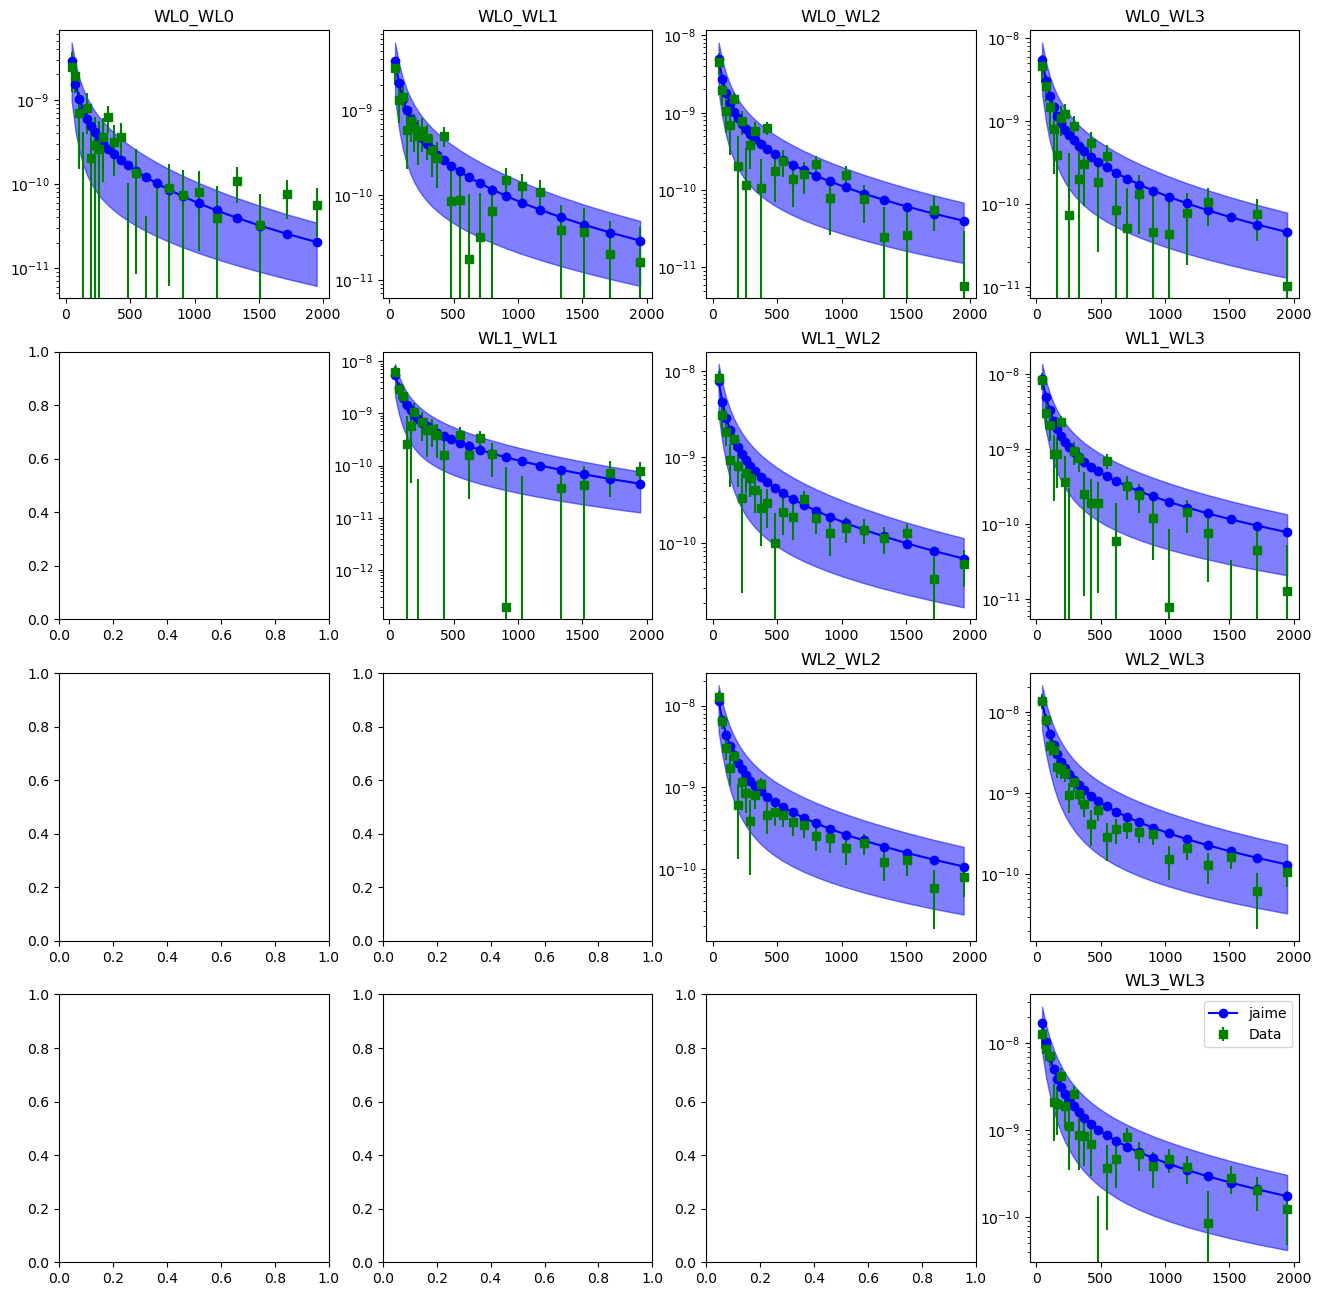

In [49]:
figure, axis = plt.subplots(4, 4, figsize=(16,16))
l = 26
for i in 0:3
    for j in 0:3
        if j >= i
            axis[i+1, j+1].errorbar(files[string("ls_2", i, "2", j)], 
                     data[idx[l]:idx[l+1]-1], 
                     yerr=err[idx[l]:idx[l+1]-1], fmt="gs", label="Data")
            axis[i+1, j+1].plot(files[string("ls_2", i, "2", j)],
                            cls_preds_m[idx[l]:idx[l+1]-1],
                            "bo-", label="jaime")
            axis[i+1, j+1].fill_between(files[string("ls_2", i, "2", j)],
                            cls_preds_m[idx[l]:idx[l+1]-1].+cls_preds_s[idx[l]:idx[l+1]-1],
                            cls_preds_m[idx[l]:idx[l+1]-1].-cls_preds_s[idx[l]:idx[l+1]-1],
                            color="b", alpha=.5)
            axis[i+1, j+1].set_title(string("WL", i, "_WL", j))
            axis[i+1, j+1].set_yscale("log")
            l += 1
        end
    end
end
plt.legend()
plt.show()

# Sample GP

In [17]:
using Turing

struct Determin{T<:Any} <: ContinuousUnivariateDistribution
  val::T
end

Distributions.rand(rng::AbstractRNG, d::Determin) = d.val
Distributions.logpdf(d::Determin, x::T) where T<:Real = zero(x)
Bijectors.bijector(d::Determin) = Identity{0}()

In [106]:
mu = fid_cosmo.Dz(vec(x)) .+ 0.1.* sin.(6*x/2);
errs = mu./10
data = rand(MvNormal(mu, errs))
cov = diagm(errs.^2)

100×100 Matrix{Float64}:
 0.01  0.0         0.0         …  0.0         0.0         0.0
 0.0   0.00987281  0.0            0.0         0.0         0.0
 0.0   0.0         0.00974835     0.0         0.0         0.0
 0.0   0.0         0.0            0.0         0.0         0.0
 0.0   0.0         0.0            0.0         0.0         0.0
 0.0   0.0         0.0         …  0.0         0.0         0.0
 0.0   0.0         0.0            0.0         0.0         0.0
 0.0   0.0         0.0            0.0         0.0         0.0
 0.0   0.0         0.0            0.0         0.0         0.0
 0.0   0.0         0.0            0.0         0.0         0.0
 0.0   0.0         0.0         …  0.0         0.0         0.0
 0.0   0.0         0.0            0.0         0.0         0.0
 0.0   0.0         0.0            0.0         0.0         0.0
 ⋮                             ⋱                          
 0.0   0.0         0.0            0.0         0.0         0.0
 0.0   0.0         0.0            0.0         0.

In [108]:
@model function model(data_vector; cov_tot=cov, fid_cosmo=fid_cosmo,
                      latent_x=latent_x, x=x)
    eta = 0.03
    l = 1
    latent_N = length(latent_x)
    v ~ MvNormal(zeros(latent_N), ones(latent_N))
    
    mu = fid_cosmo.Dz(vec(latent_x))
    K = sqexp_cov_fn(latent_x; eta=eta, l=l)
    latent_gp = latent_GP(mu, v, K)
    gp = conditional(latent_x, x, latent_gp, sqexp_cov_fn;
                      eta=eta, l=l)
    
    data_vector ~ MvNormal(gp, cov_tot)
    
    return (gp=gp,)
end;

In [109]:
chain = sample(model(data), HMC(0.005, 100), 100)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:44


Chains MCMC chain (100×20×1 Array{Float64, 3}):

Iterations        = 1:1:100
Number of chains  = 1
Samples per chain = 100
Wall duration     = 46.22 seconds
Compute duration  = 46.22 seconds
parameters        = v[1], v[2], v[3], v[4], v[5], v[6], v[7], v[8], v[9], v[10], v[11]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

        v[1]    0.3268    0.2118     0.0212    0.0273   46.9694    0.9931      ⋯
        v[2]    0.7603    0.5349     0.0535    0.1167    3.5360    1.2327      ⋯
        v[3]   -0.5059    0.9392     0.0939    0.2481    2.2642    1.4653      ⋯
        v[4]   -2.0020    0.7377     0.0738    0.1571    9.2192    1.1169      ⋯
        v[5]   -0.0111    0.5757     0.0576    0.1155   20.7361    1.0

In [110]:
function generated_quantities(model::DynamicPPL.Model, chain::MCMCChains.Chains)
   varinfo = DynamicPPL.VarInfo(model)
   iters = Iterators.product(1:size(chain, 1), 1:size(chain, 3))
   return map(iters) do (sample_idx, chain_idx)
       DynamicPPL.setval!(varinfo, chain, sample_idx, chain_idx)
       model(varinfo)
   end
end

generated_quantities (generic function with 1 method)

In [129]:
derived = generated_quantities(model(data), chain)

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following key

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following key

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following key

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/jaime/.julia/packages/DynamicPPL/e6mZw/src/varinfo.jl:1327
┌ Warning: the following key

100×1 Matrix{NamedTuple{(:gp,), Tuple{Vector{Float64}}}}:
 (gp = [1.1493973432691507, 1.1403612782597323, 1.130289707520604, 1.1192209510468414, 1.1071967786770094, 1.094262224523968, 1.0804653839977176, 1.06585719465724, 1.050491202241622, 1.034423313333534  …  0.5710558234007925, 0.5707894371571733, 0.5701220663845694, 0.5690506263860434, 0.5675733886268323, 0.5656899464097048, 0.5634011777891336, 0.5607092059325455, 0.5576173571289451, 0.5541301166373975],)
 (gp = [1.0502198249853334, 1.0428572099124833, 1.0344392366547084, 1.0249950204382503, 1.0145573588749077, 1.003162598042949, 0.990850478746569, 0.9776639637660486, 0.9636490470480602, 0.9488545459166088  …  0.3452297136445962, 0.3427702913438276, 0.3400297491897144, 0.33701357025437384, 0.33372839237423146, 0.3301819213481514, 0.32638284250029437, 0.32234073123714346, 0.31806596320249797, 0.3135696246052853],)
 (gp = [1.090264185082839, 1.0854567531397634, 1.0796570924178168, 1.0728886558295019, 1.0651781889175633, 1.0565556233

In [140]:
using DataFrames

In [146]:
gps = vec([row.gp for row in derived])
CSV.write("gps.csv", DataFrame(gps, :auto), header = false)

"derived.csv"

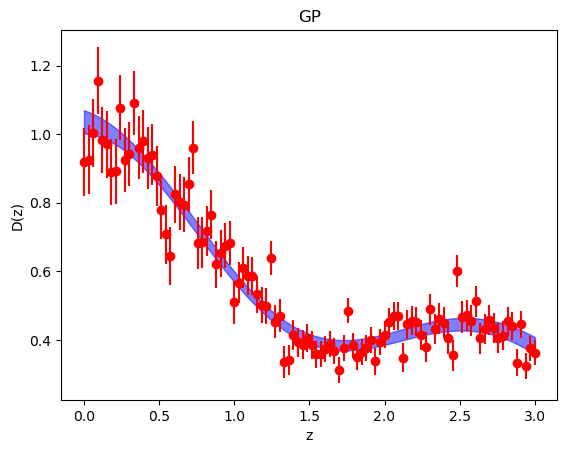

In [134]:
plt.errorbar(x, data, yerr=errs, fmt="ro")
plt.fill_between(x, mean(gps).+std(gps),
                 mean(gps).-std(gps), color="b", alpha=.5);
plt.xlabel("z")
plt.ylabel("D(z)")
plt.title("GP");

## Actual data

In [ ]:
files = npzread("../data/DESY1_cls/gcgc_gcwl_wlwl.npz")
cov_tot = files["cov"]
data_vector = files["cls"]

fid_cosmo = Cosmology()
N = 100
latent_x = Vector(0:0.3:3)
x = Vector(range(0., stop=3., length=N));

In [ ]:
@model function model(data_vector; cov_tot=cov_tot, fid_cosmo=fid_cosmo,
                      latent_x=latent_x, x=x)
    eta ~ Uniform(0.0, 0.5)
    l ~ Uniform(0.1, 3)
    latent_N = length(latent_x)
    v ~ MvNormal(zeros(latent_N), ones(latent_N))
    
    Ωm ~ Uniform(0.1, 0.9)
    Ωb = 0.05 #~ Uniform(0.03, 0.07)
    h ~ Uniform(0.55, 0.91)
    s8 = 0.811
    ns = 0.96 
    
    nuisances = Dict()
    
    mu = fid_cosmo.Dz(vec(latent_x))
    K = sqexp_cov_fn(latent_x; eta=eta, l=l)
    latent_gp = latent_GP(mu, v, K)
    gp = conditional(latent_x, x, latent_gp, sqexp_cov_fn;
                      eta=eta, l=l)
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit", 
                                     custom_Dz=gp)
    
    theory = Theory(cosmology, files;
                    Nuisances=nuisances)
    data_vector ~ MvNormal(theory, cov_tot)
end;

In [ ]:
cycles = 10
iterations = 50
TAP = 0.60
adaptation = 10
#nchains = Threads.nthreads()


# Start sampling.
folpath = "../chains"
folname = string("DES_test_gp_", "TAP", TAP)
folname = joinpath(folpath, folname)

mkdir(folname)
println("Created new folder")

for i in 1:cycles
    if i == 1
        chain = sample(model(data_vector), NUTS(adaptation, TAP), 
                       iterations, progress=true; save_state=true)
    else
        old_chain = read(joinpath(folname, string("chain_", i-1, ".jls")), Chains)
        chain = sample(model(data_vector), NUTS(adaptation, TAP), 
                       iterations, progress=true; save_state=true,
                       resume_from=old_chain)
    end 
    write(joinpath(folname, string("chain_", i,".jls")), chain)
    CSV.write(joinpath(folname, string("chain_", i,".csv")), chain)
end